![tower_bridge](tower_bridge.jpeg)

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [29]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in the data
weather = pd.read_csv("london_weather.csv")

# Start coding here
# Use as many cells as you like

In [30]:
weather.head(10)

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
5,19790106,5.0,3.8,39.0,8.3,-0.5,-6.6,0.7,102780.0,1.0
6,19790107,8.0,0.0,13.0,8.5,1.5,-5.3,5.2,102520.0,0.0
7,19790108,8.0,0.1,15.0,5.8,6.9,5.3,0.8,101870.0,0.0
8,19790109,4.0,5.8,50.0,5.2,3.7,1.6,7.2,101170.0,0.0
9,19790110,7.0,1.9,30.0,4.9,3.3,1.4,2.1,98700.0,0.0


In [31]:
weather.isnull().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [32]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [33]:
weather.dropna(inplace=True)
weather.isnull().sum()

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

In [34]:
# Convert date to datetime
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m%d')

# Extract temporal features
weather['month'] = weather['date'].dt.month
weather['dayofyear'] = weather['date'].dt.dayofyear
# weather['weekday'] = weather['date'].dt.weekday  # Optional

# Drop original date column if not using it directly
weather.drop(columns=['date'], inplace=True)

weather.head(10)

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,month,dayofyear
0,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1,1
1,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,1,2
2,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,1,3
3,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,1,4
4,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,1,5
5,5.0,3.8,39.0,8.3,-0.5,-6.6,0.7,102780.0,1.0,1,6
6,8.0,0.0,13.0,8.5,1.5,-5.3,5.2,102520.0,0.0,1,7
7,8.0,0.1,15.0,5.8,6.9,5.3,0.8,101870.0,0.0,1,8
8,4.0,5.8,50.0,5.2,3.7,1.6,7.2,101170.0,0.0,1,9
9,7.0,1.9,30.0,4.9,3.3,1.4,2.1,98700.0,0.0,1,10


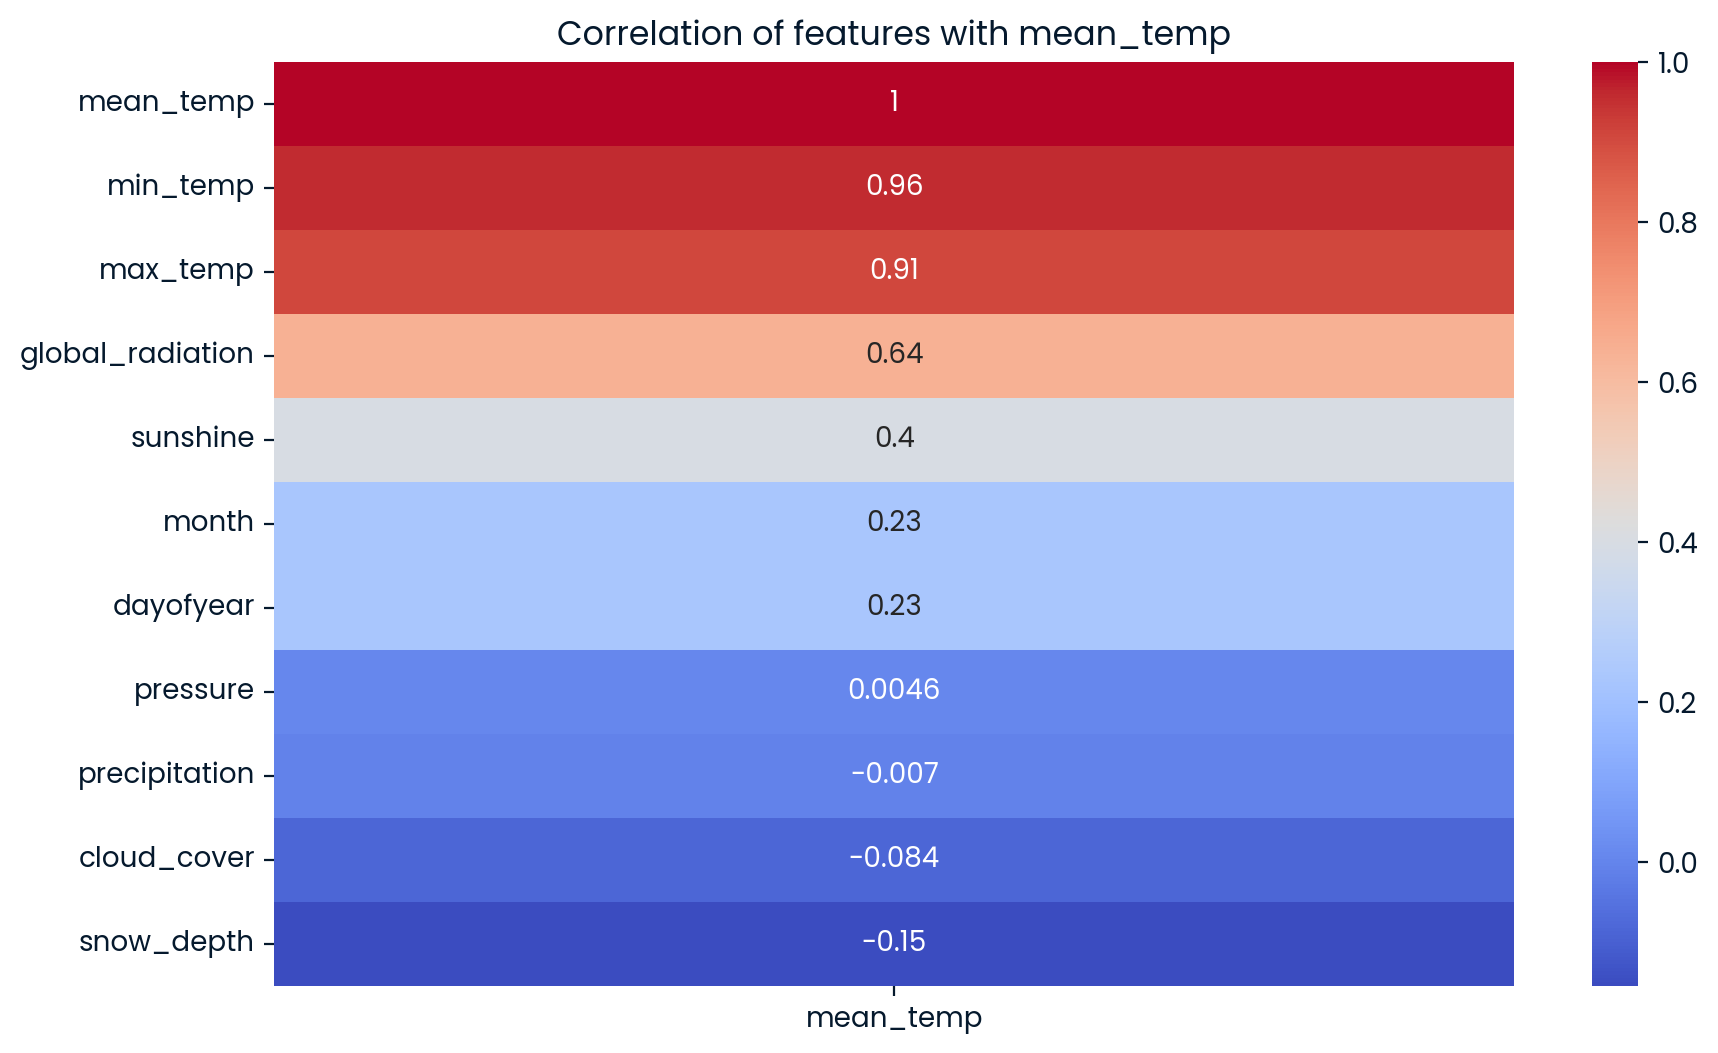

In [35]:
corr_matrix = weather.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[['mean_temp']].sort_values(by='mean_temp', ascending=False), 
            annot=True, cmap='coolwarm')
plt.title("Correlation of features with mean_temp")
plt.show()

In [36]:
# Final feature list based on correlation
final_features = [
    'min_temp', 'max_temp',
    'global_radiation', 'sunshine',
    'month', 'dayofyear'
]

def prepare_data(df, target='mean_temp'):
    X = df[final_features]
    y = df[target]
    return train_test_split(X, y, test_size=0.2, shuffle=False)  # time-aware split

In [20]:
client = mlflow.MlflowClient()

In [21]:
all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1753337671896, experiment_id='0', last_update_time=1753337671896, lifecycle_stage='active', name='Default', tags={}>]


In [22]:
from datetime import datetime

experiment_description = (
    "This is an experiment to predict the mean temperature in London using various regression models. "
    "This experiment will explore different feature sets, model configurations, and evaluation metrics to find the best approach for accurate temperature prediction."
)

experiment_tags = {
    "project_name": "London-mean-temperature-prediction",
    "project_objective": "Run experiments to determine the best regression model for predicting London mean temperature.",
    "mlflow-note-author": "Endie",
    "mlflow-note-date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "mlflow.note.content": experiment_description,
}

london_mean_temp = client.create_experiment(name="mean_temp_model", tags=experiment_tags)

In [23]:
print(f"Experiment created with ID: {london_mean_temp}")

Experiment created with ID: 394701296693947814


In [26]:
from sklearn.pipeline import Pipeline


def train_and_log_model(model_name, model, X_train, X_test, y_train, y_test, use_scaler=False):
    with mlflow.start_run(experiment_id=london_mean_temp, run_name=model_name):
        # Conditionally apply scaling
        if use_scaler:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model)
            ])
        else:
            pipeline = Pipeline([
                ('model', model)
            ])
        
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)

        # Log model params
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("features", ",".join(final_features))
        mlflow.log_param("scaling", use_scaler)

        # Log metrics
        rmse = mean_squared_error(y_test, preds, squared=False)
        
        mlflow.log_metric("rmse", rmse)
        

        # Log full pipeline
        mlflow.sklearn.log_model(pipeline, "model")

        print(f"{model_name} -> RMSE: {rmse:.3f}")

In [27]:
X_train, X_test, y_train, y_test = prepare_data(weather.copy())

# Run experiments
train_and_log_model("LinearRegression", LinearRegression(), X_train, X_test, y_train, y_test, use_scaler=True)
train_and_log_model("RandomForest", RandomForestRegressor(n_estimators=100, max_depth=10), X_train, X_test, y_train, y_test)
train_and_log_model("DecisionTree", DecisionTreeRegressor(max_depth=10), X_train, X_test, y_train, y_test)


LinearRegression -> RMSE: 0.938
RandomForest -> RMSE: 0.920
DecisionTree -> RMSE: 1.056


In [28]:
runs = client.search_runs(
    experiment_ids=[london_mean_temp],
    filter_string="metrics.rmse <= 3",
    order_by=["metrics.rmse ASC"]
)

# Store in experiment_results variable
experiment_results = pd.DataFrame([{
    "run_id": run.info.run_id,
    "model_type": run.data.params.get("model_type"),
    "rmse": run.data.metrics.get("rmse"),
    "r2": run.data.metrics.get("r2_score"),
    "scaling": run.data.params.get("scaling"),
    "features": run.data.params.get("features")
} for run in runs])

print("Filtered experiment results (RMSE ≤ 3):")
print(experiment_results)

Filtered experiment results (RMSE ≤ 3):
                             run_id  ...                                           features
0  cf816dd87a0445798996f9d87ec3d91a  ...  min_temp,max_temp,global_radiation,sunshine,mo...
1  b7f12be56c2a4ce38606f42a619640cb  ...  min_temp,max_temp,global_radiation,sunshine,mo...
2  25509560650844d4a6f8599e5b60b5c1  ...  min_temp,max_temp,global_radiation,sunshine,mo...

[3 rows x 6 columns]
